In [879]:
import torch
import os, glob
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
import logomaker
import matplotlib.pyplot as plt
import pandas as pd

## Creating and training the Network

In [420]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [387]:
data_pos=[]
path='/home/ubuntu/tmp/data/pos/'
for filename in glob.glob(os.path.join(path,'*.txt')):
    with open(os.path.join(os.getcwd(),filename),'r') as file:
        while line := file.readline():
            data_pos.append(line)   

data_neg=[]
path='/home/ubuntu/tmp/data/neg/'
for filename in glob.glob(os.path.join(path,'*.txt')):
    with open(os.path.join(os.getcwd(),filename),'r') as file:
        while line := file.readline():
            data_neg.append(line)

In [388]:
# Usually the number of negative data points will be more than the positive data point, since positive data is created
# by applying filter to the raw data. Whereas negative data points are also created by applying filter to the
# raw data, but the conditions are less stringent. This logic may change in the future.

total_rows=len(data_neg)+len(data_pos)
merge=[[[] for x in range(2)] for y in range(0,total_rows)]
index=0
diff=abs(len(data_neg)-len(data_pos))
for i in range(0,len(data_pos)):
    merge[index][0]=data_pos[i].strip().upper()
    merge[index][1]=1.0
    index=index+1
    merge[index][0]=data_neg[i].strip().upper()
    merge[index][1]=0.0
    index=index+1
    if diff >= 1:
        merge[index][0]=data_neg[i].strip().upper()
        merge[index][1]=0.0
        index=index+1
        diff = diff -1


In [389]:
merge[5565][0]

'AGGAAAACGTGAATCTATGTGGACTGTTCCAAACAATCCCAATTCCCCAGCTAATGAGCTCAAAGCTTTGGAAACAGGGAAAATGTCAAAGGATCCCGATTCGCCAGCTAATGAGCTGAAAGGCAATGAACCAGGAGAAGTGTCAAAAGA'

In [390]:
len(data_neg)+len(data_pos)

13190

In [391]:
# All the nucleotide are converted into a upper case letter. There are instance where the sequence may contain both upper and lower letter.
# Lower and Upper case has different interpretation, lower may be "soft mask" not completely align to the region. Lower case also means that
# it may be a repetative statement. In case of gene sequence it may mean introns and Exons (Upper). 
# If N/n is there then it will be assigned a value of [0.,0.,0.,0.]

def dna_to_one_hot_encoding(genome):
    one_hot=list()
    nucli_map={"A":[1., 0., 0., 0.], "C": [0., 1., 0., 0.], "G": [0., 0., 1., 0.], "T":[0., 0., 0., 1.]}
    #print(genome)
    for nucleotide in genome:
        one_hot.append(nucli_map[nucleotide]  if nucleotide in nucli_map.keys() else [0., 0., 0., 0.])

    return np.array(one_hot).T

In [392]:
temp=dna_to_one_hot_encoding(merge[13189][0])
temp

array([[1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0.,

In [393]:
# Shuffle all the indexes

index_shuffle=list(range(total_rows))
random.shuffle(index_shuffle)

train_percentage=0.7
train_split=int(len(index_shuffle)*train_percentage)
remaining=total_rows-train_split
validation_split=int(remaining*0.7)

train_idx=index_shuffle[:train_split]
validation_idx=index_shuffle[train_split:train_split+validation_split]
test_idx=index_shuffle[train_split+validation_split:]

In [394]:
# collect all the sequences and its respective label from the indexs what is already calculated for the three different splits 

train_data_raw=[]
for i in train_idx:
    train_data_raw.append(merge[i])

validation_data_raw=[]
for i in validation_idx:
    validation_data_raw.append(merge[i])

test_data_raw=[]
for i in test_idx:
    test_data_raw.append(merge[i])

In [395]:
# The custom Dataset class. The input to the function genome is a 2D data set, where the 0th dimension of an element is the sequence and
# 1st dimension is the label of the sequence. That is why x[0] is used, which contain the sequence part and x[1] contain the label. 

class genome_to_one_hot(Dataset):
    def __init__(self,genome):
        self.dna=genome

        self.genome_one_hot=torch.stack([torch.tensor(dna_to_one_hot_encoding(x[0])) for x in self.dna])
        self.labels=torch.tensor(list(x[1] for x in self.dna))

    def __len__(self):
        return len(self.dna)
    
    def __getitem__(self,id):
        one_hot_dna=self.genome_one_hot[id]
        labels=self.labels[id]

        return one_hot_dna,labels

In [396]:
# create the dataset

test_data=genome_to_one_hot(test_data_raw)
train_data=genome_to_one_hot(train_data_raw)
validation_data=genome_to_one_hot(validation_data_raw)

train_dataloader=DataLoader(train_data,batch_size=512,shuffle=True)
validation_dataloader=DataLoader(validation_data,batch_size=512,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=512)

In [397]:
class deep_peak_cnn(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.conv1=nn.Conv1d(in_channels=4,out_channels=32,kernel_size=11,stride=1,padding=0)
        self.pool1=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv2=nn.Conv1d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=0)
        self.pool2=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv3=nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool3=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv4=nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool4=nn.MaxPool1d(kernel_size=3,stride=2)

        self.fc1=nn.Linear(in_features=(128*5),out_features=2048)
        self.fc2=nn.Linear(in_features=2048,out_features=2048)
        self.fc3=nn.Linear(in_features=2048,out_features=num_classes)

    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=self.pool3(F.relu(self.conv3(x)))
        x=self.pool4(F.relu(self.conv4(x)))

        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,0.6)
        x=F.relu(self.fc2(x))
        x=F.dropout(x,0.6)
        x=F.relu(self.fc3(x))

        return x


In [416]:
model=deep_peak_cnn().to(device)
optimizer=optim.Adam(params=model.parameters(),lr=0.0001)
loss_fn=nn.CrossEntropyLoss()

In [417]:
# convert the data to float

def train(model,train_loader,optimizer,epochs,device):
    model.train()
    for batch_ids, (data,labels) in enumerate(train_loader):
        labels=labels.type(torch.LongTensor)
        data,labels=data.to(device, dtype=torch.float32),labels.to(device)

        optimizer.zero_grad()
        model_output=model(data)
        loss=loss_fn(model_output,labels)
        loss.backward()
        optimizer.step()

        if (batch_ids+1)%6 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epochs,batch_ids*len(data),len(train_loader.dataset),
                100.*batch_ids/len(train_loader),loss.item()))


In [418]:
# f1_score is also calculated. 

def validate(model, validation_loader,device):
    model.eval()
    correct=0
    with torch.no_grad():
        for data,labels in validation_loader:
            data,labels=data.to(device,dtype=torch.float32), labels.to(device,dtype=torch.float32)
            y_hat=model(data)
            _,y_pred=torch.max(y_hat,1)
            correct+=(y_pred==labels).sum().item()
            #print("f1_score:", f1_score(labels.cpu().data,y_pred.cpu()))
        print("\n Test Set: Average loss: xx , Accuracy:{}/{} ({:.0f}%, f1_score:{})".format(
            correct,len(validation_data),100.*correct/len(validation_data),f1_score(labels.cpu().data,y_pred.cpu())))
        print("="*50)

In [419]:
if __name__=='__main__':
    seed=42
    Epochs=100

    for epoch in range(1,Epochs+1):
        train(model,train_dataloader,optimizer,epoch,device)
        validate(model,validation_dataloader,device)

Train Epoch: 1 [2560/9233 (26%)]	Loss: 0.683108
Train Epoch: 1 [5632/9233 (58%)]	Loss: 0.681863
Train Epoch: 1 [8704/9233 (89%)]	Loss: 0.673304

 Test Set: Average loss: xx , Accuracy:1582/2769 (57%, f1_score:0.0)
Train Epoch: 2 [2560/9233 (26%)]	Loss: 0.674464
Train Epoch: 2 [5632/9233 (58%)]	Loss: 0.687068
Train Epoch: 2 [8704/9233 (89%)]	Loss: 0.673895

 Test Set: Average loss: xx , Accuracy:1582/2769 (57%, f1_score:0.0)
Train Epoch: 3 [2560/9233 (26%)]	Loss: 0.664211
Train Epoch: 3 [5632/9233 (58%)]	Loss: 0.667384
Train Epoch: 3 [8704/9233 (89%)]	Loss: 0.662929

 Test Set: Average loss: xx , Accuracy:1582/2769 (57%, f1_score:0.0)
Train Epoch: 4 [2560/9233 (26%)]	Loss: 0.676531
Train Epoch: 4 [5632/9233 (58%)]	Loss: 0.680842
Train Epoch: 4 [8704/9233 (89%)]	Loss: 0.665258

 Test Set: Average loss: xx , Accuracy:1582/2769 (57%, f1_score:0.0)
Train Epoch: 5 [2560/9233 (26%)]	Loss: 0.669793
Train Epoch: 5 [5632/9233 (58%)]	Loss: 0.658925
Train Epoch: 5 [8704/9233 (89%)]	Loss: 0.662172


## Printing the 1st layers filter

In [321]:
m = nn.Conv1d(4, 32, 11, stride=1,padding=0)
input=torch.randn(1,4,150)
output=m(input)
output.shape

torch.Size([1, 32, 140])

In [378]:
m=nn.MaxPool1d(3,stride=2)
input=m(output)
input.shape

torch.Size([1, 32, 69])

In [424]:
# To extract the weight, bias and the layer type of the model. Conv1d layers from the model will be extracted and the associated
# weights and biases will get extracted. 

def cnn_layers_property(model):
    
    model_layers=list(model.children())

    cnn_layer_weights=[]
    cnn_layers=[]
    cnn_layer_bias=[]

    for i in range(len(model_layers)):
        if type(model_layers[i]) == nn.Conv1d:
            cnn_layers.append(model_layers[i])
            cnn_layer_weights.append(model_layers[i].weight)
            cnn_layer_bias.append(model_layers[i].bias)

    return cnn_layer_weights, cnn_layer_bias, cnn_layers

In [446]:
# Print only the filters of the 1st Conv1d layer, the weight for the 1st Conv1d is stored in the 0th index. The weights of the
# 2nd Conv1d layer is stored in the 1st index. Since it is a list of all the layers the length is 4 (for the current network). 
# 0th index is the 1st conv1d of the size torch.Size([32, 4, 11]). 

def show_cnn_filters(cnn_layers_weight):
    
    columns=8
    rows=int(np.ceil(cnn_layers_weight[0].shape[0]/columns))
    filter_width=cnn_layers_weight[0].shape[2]
    layer_weight=cnn_layers_weight[0]

    plt.figure(figsize=(20,17))

    for i, filter in enumerate(layer_weight):
        ax=plt.subplot(rows,columns,i+1)
        ax.imshow(filter.cpu().detach(),cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A','C','G','T'])
        ax.set_xticks(np.arange(filter_width))
        ax.set_title(f"Filter{i}")

    plt.tight_layout()
    plt.show()


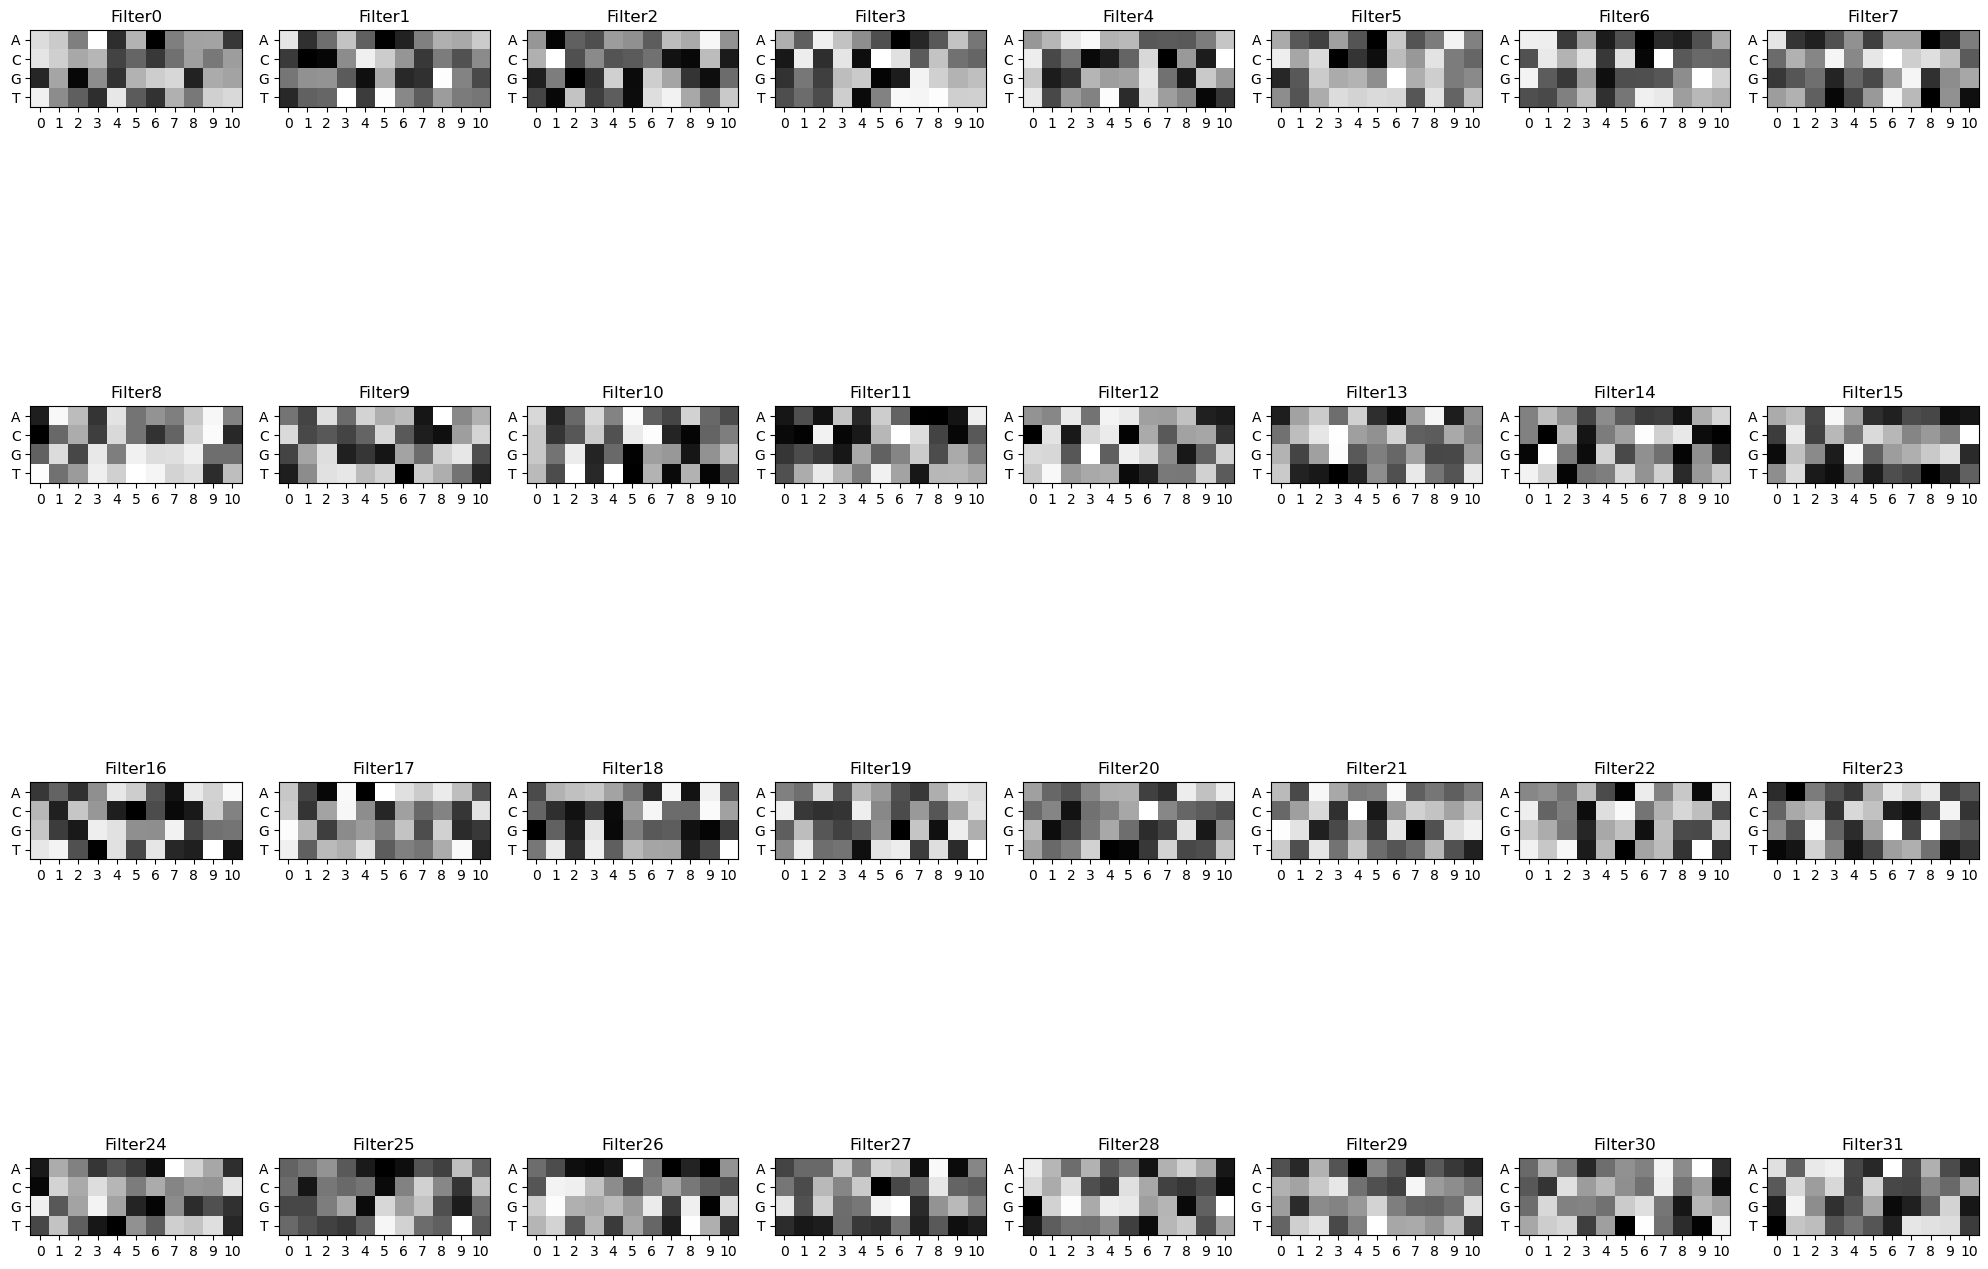

In [447]:
cnn_layers_weights,cnn_layer_bias,cnn_layers = cnn_layers_property(model)
show_cnn_filters(cnn_layers_weights)

In [454]:
# Pass the data through the 1st layer. 

def genome_to_weights(genome,cnn_layer):

    with torch.no_grad():
        genome=genome.to(device,dtype=torch.float32)
        weights=cnn_layer(genome)
        return weights

In [480]:
# using the raw input data so the data needs to be converted to a tensor. The length of weights will be the total number of data points.
# e.g length will be 1188 (total input data size) and each of size torch.Size([1, 32, 140]). Since need to show the activation pattern of the 1st layer
# cnn_layers[0] is used.

weights=[]
for genome,_ in test_data_raw:
    genome_one_hot=torch.stack([torch.tensor(dna_to_one_hot_encoding(genome))])
    weights.append(genome_to_weights(genome_one_hot,cnn_layers[0]))
    

In [650]:
# Convert the weights of the input data to a position weight matrix (pwm). 

torch.set_printoptions(threshold=10000)
def create_pwm(weights,test_data_raw,cnn_layers):
    filter_width=cnn_layers.kernel_size[0]
    
    pwm=np.zeros((cnn_layers.out_channels,cnn_layers.in_channels,filter_width),dtype=int)
    for i,weight in enumerate(weights):
        for filter_idx in range(cnn_layers.out_channels):
            #print(filter_idx)
            above_thresh=torch.where(weight[0][filter_idx] > 0)[0]
            for j in above_thresh:
                pwm[filter_idx]=pwm[filter_idx] + dna_to_one_hot_encoding(test_data_raw[i][0][j:j+filter_width])
                #print(test_data_raw[i][0][j:j+filter_width])
                #print(dna_to_one_hot_encoding(test_data_raw[i][0][j:j+filter_width]))     
                #print(pwm[filter_idx])  
            
    return pwm    
        

In [651]:
#filter_width=cnn_layers[0].kernel_size[0]
pwm=create_pwm(weights,test_data_raw,cnn_layers[0])
pwm[0]

array([[21308, 21172, 21239, 28627, 14933, 23117, 12383, 16837, 21822,
        19359, 10252],
       [18332, 18773, 21237, 18774, 12421, 10748, 13753, 14075, 19025,
        11785, 16308],
       [ 5710, 14351,  8576, 12608, 11173, 19714, 25323, 19224,  9320,
        14854, 17188],
       [24447, 15501, 18745,  9788, 31270, 16218, 18338, 19661, 19630,
        23799, 26049]])

In [694]:
# In the datframe creation Transform is used coz it expect the data to be in the form N x 4 but the
# pwm is in shape 4xN.

def show_motif_and_filter(pwm,cnn_layer_weights):
    
    num_filters=len(pwm)
    num_cols=8
    num_rows=int(np.ceil(num_filters/num_cols))*2 +1
    filter_width=len(pwm[0][0])

    plt.figure(figsize=(20,17))

    motif_row=0
    for i, filter in enumerate(cnn_layer_weights[0]):
        if i%num_cols == 0:
            motif_row +=num_cols
        
        ax1=plt.subplot(num_rows,num_cols,i+motif_row+1)
        ax1.imshow(filter.cpu().detach(),cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A','C','G','T'])
        ax1.set_xticks(np.arange(filter_width))
        ax1.set_title(f"Filter{i}")

        ax2=plt.subplot(num_rows,num_cols,i+motif_row+1+num_cols)
        pwm_dataframe=pd.DataFrame(pwm[i].T,columns=['A','C','G','T'])
        motif_df=logomaker.transform_matrix(pwm_dataframe, from_type='counts',to_type='information')
        logo=logomaker.Logo(motif_df,ax=ax2)
        ax2.set_ylim(0,1)
        ax2.set_title(f"Filter{i}")

    plt.tight_layout()

        

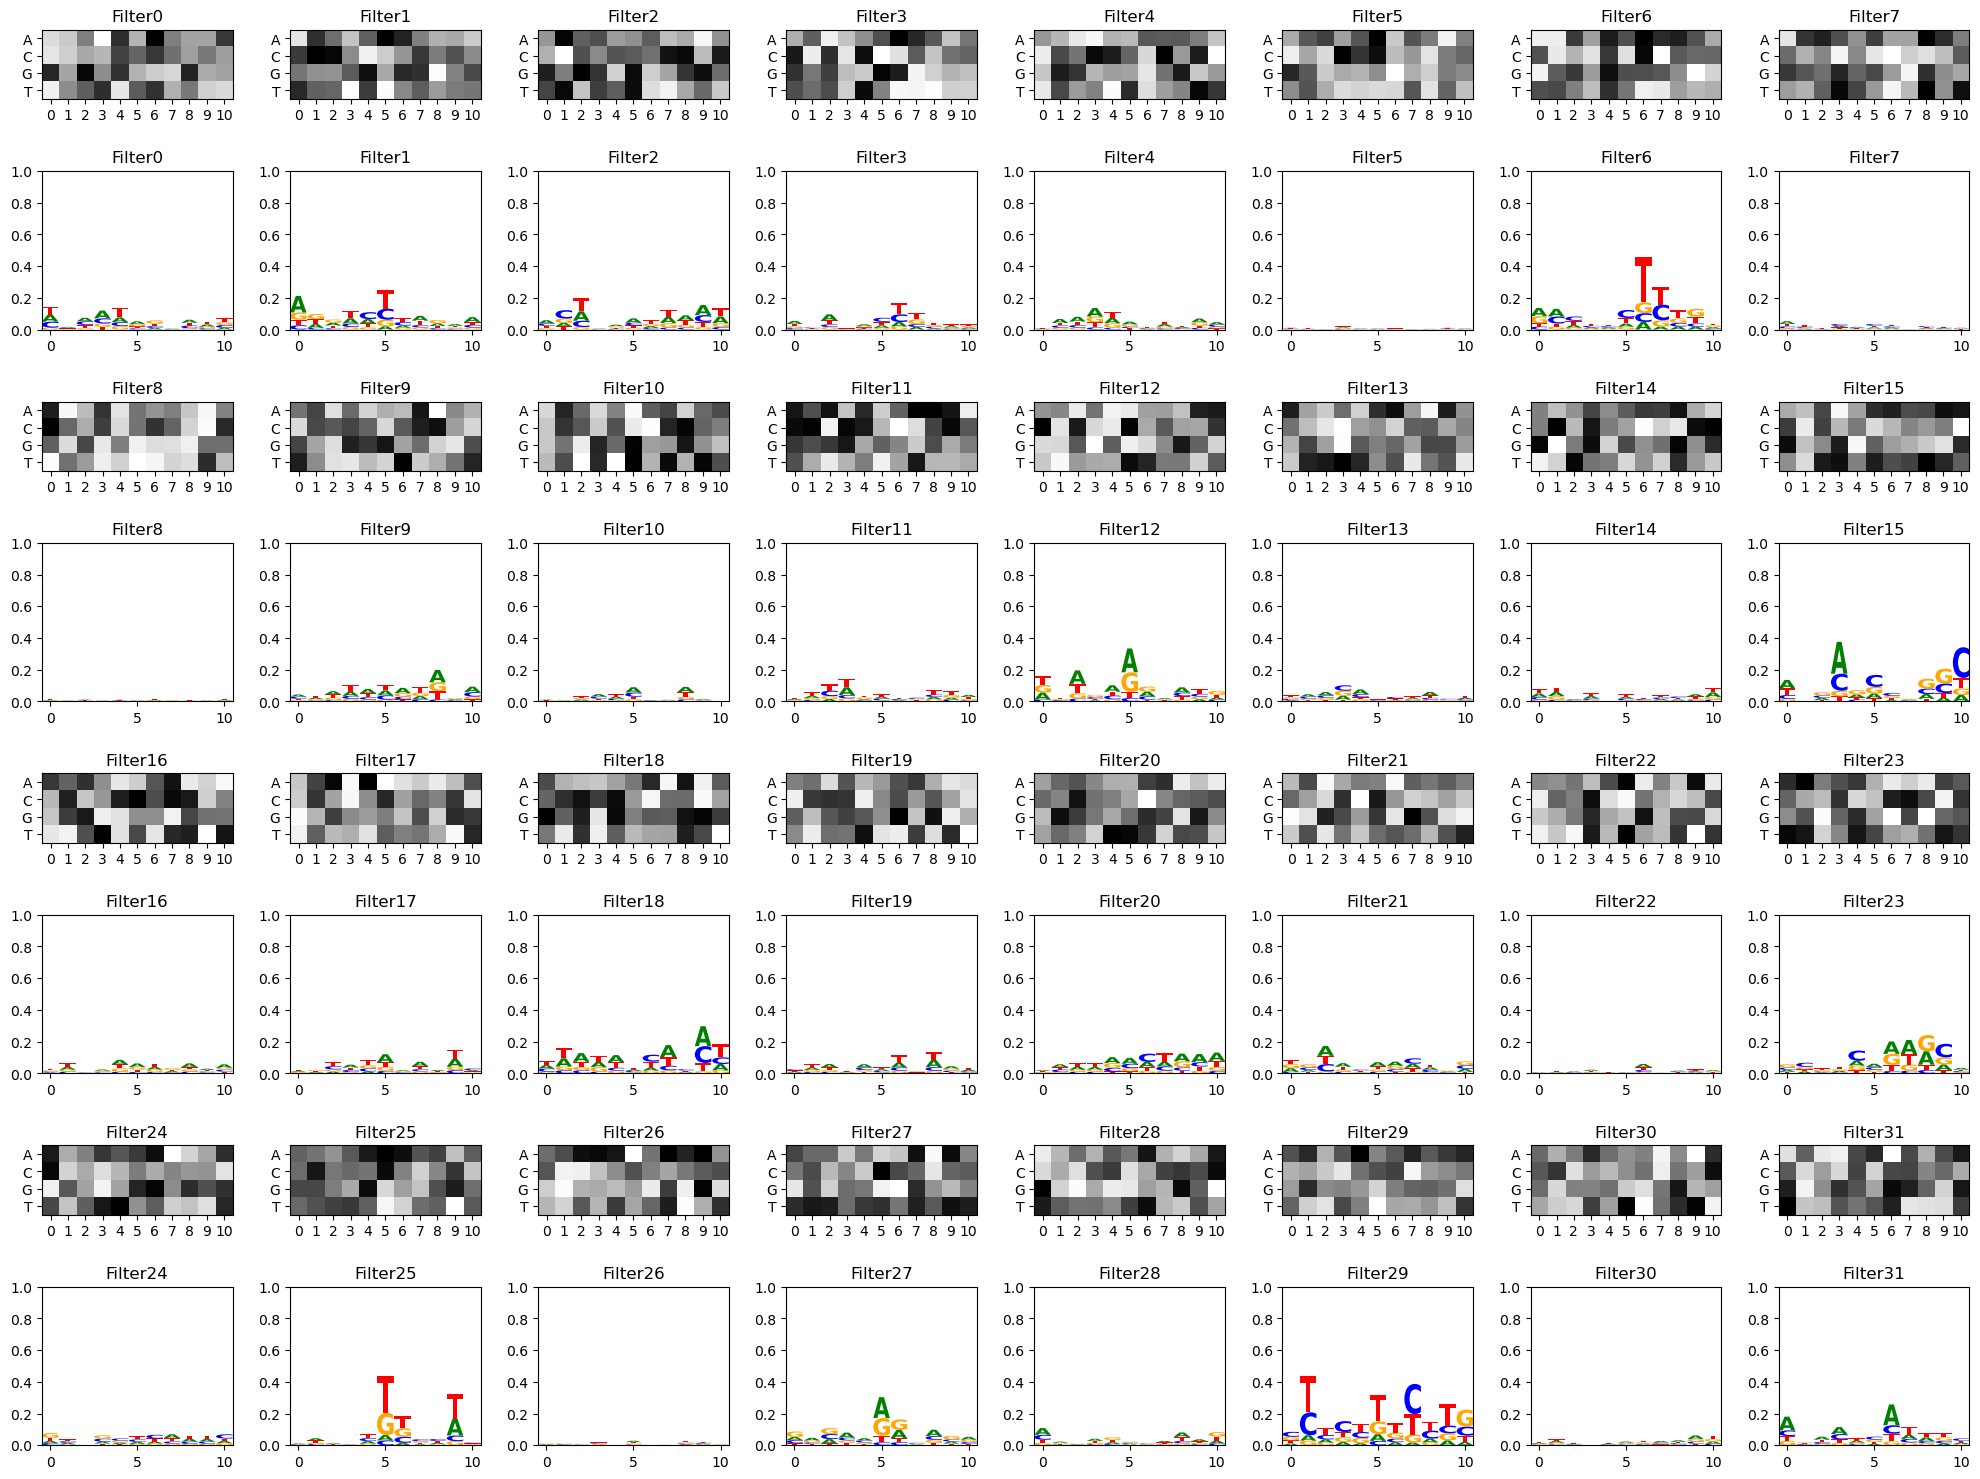

In [695]:
if weights[0].shape[1] == len(pwm):
    show_motif_and_filter(pwm,cnn_layers_weights)

In [485]:
weights[1187].shape

torch.Size([1, 32, 140])

In [628]:
cnn_layers[0].out_channels

32

In [545]:
test_data_raw[23][0][2:6]

'AACA'

In [581]:
weights[34][0][31].shape

torch.Size([140])

In [575]:
weights[34][0].shape

torch.Size([32, 140])

In [699]:
len(cnn_layers_weights)

4

In [691]:
crp_df = logomaker.get_example_matrix('crp_energy_matrix',print_description=False)

In [701]:
crp_df

,A,C,G,T
pos,,,,
0,-0.183642,0.155864,0.094136,-0.066358
1,-0.290123,0.277778,0.111111,-0.098765
2,-0.276235,0.316358,0.168210,-0.208333
3,-0.226852,0.285494,0.297840,-0.356481
4,-0.060185,0.143519,0.057099,-0.140432
5,0.294753,-0.168210,0.486111,-0.612654
6,0.179012,0.617284,-0.851852,0.055556
7,0.033951,0.212963,0.324074,-0.570988
8,0.444444,0.592593,-1.117284,0.080247


## Explaining with other algorithms

In [918]:
from captum.attr import DeepLift
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import DeepLiftShap

In [738]:
data,labels=next(iter(test_dataloader))

In [816]:
idx=7
#data.to(device, dtype=torch.float32),labels.to(device)
data_test=data[idx].unsqueeze(0).to(device, dtype=torch.float32)
data_test.requires_grad = True
model.eval()

deep_peak_cnn(
  (conv1): Conv1d(4, 32, kernel_size=(11,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool3): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool4): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2, bias=True)
)

In [817]:

def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    #tensor_attributions = algorithm.attribute(input,target=1.0, **kwargs)
    tensor_attributions = algorithm.attribute(input, **kwargs)
    
    return tensor_attributions

In [818]:
#labels[idx].to(device, dtype=torch.float32).shape
#print(labels[7])
data_test.shape

torch.Size([1, 4, 150])

In [819]:
labels_idx=int(labels[7].item())
labels_idx

1

In [931]:
#labels_idx=labels[idx]
attribution_values=[]
print(labels_idx)
dl=DeepLift(model)
attribution_dl=attribute_image_features(dl,data_test, target=labels_idx, baselines=data_test*0)
attribution_values.append(attribution_dl)
attr_dl = np.transpose(attribution_dl.cpu().detach().numpy(), (1, 2, 0))

1


In [830]:
attribution_dl.squeeze(0).T

tensor([[-0.0170, -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0063],
        [ 0.0000,  0.0000,  0.0053,  0.0000],
        [ 0.0206, -0.0000, -0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0347,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0255],
        [ 0.0000,  0.0484, -0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000, -0.0290],
        [-0.0000,  0.0752,  0.0000, -0.0000],
        [ 0.0977, -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.0070, -0.0000],
        [ 0.0674,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.1886,  0.0000, -0.0000],
        [ 0.1119, -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.1269,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0103],
        [-0.0000,  0.0000,  0.2771,  0.0000],
        [-0.0000, -0.0000, -0.0000, -0.1742],
        [-0.0000, -0.0000,  0.0000,  0.0383],
        [ 0.0000,  0.0000,  0.0000, -0.1886],
        [ 0.0000,  0.0000,  0.3553,  0.0000],
        [-0.0000,  0.0000, -0.0936

In [932]:
def dna_attribution_plot(attribution_value):
 
    plt.figure(figsize=(20,2))

    ax1=plt.subplot(1,1,1)
    atr_dataframe=pd.DataFrame(attribution_value.cpu().detach().squeeze(0).T,columns=['A','C','G','T'])
    logo=logomaker.Logo(atr_dataframe, shade_below=.5, fade_below=.5,ax=ax1)
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)

    plt.tight_layout()

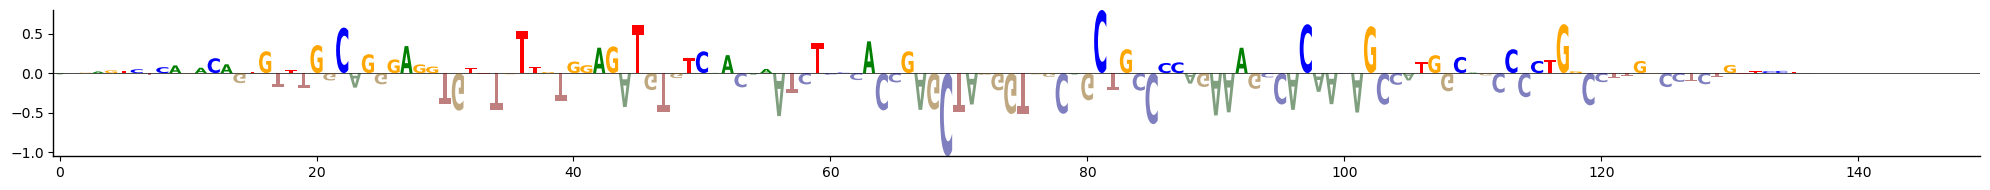

In [873]:
dna_attribution_plot(attribution_dl)

In [933]:
saliency=Saliency(model)

saliency_grads=saliency.attribute(data_test, target=labels_idx)
attribution_values.append(saliency_grads)
#grads=np.transpose(grads.cpu().detach().numpy(),(1,2,0))

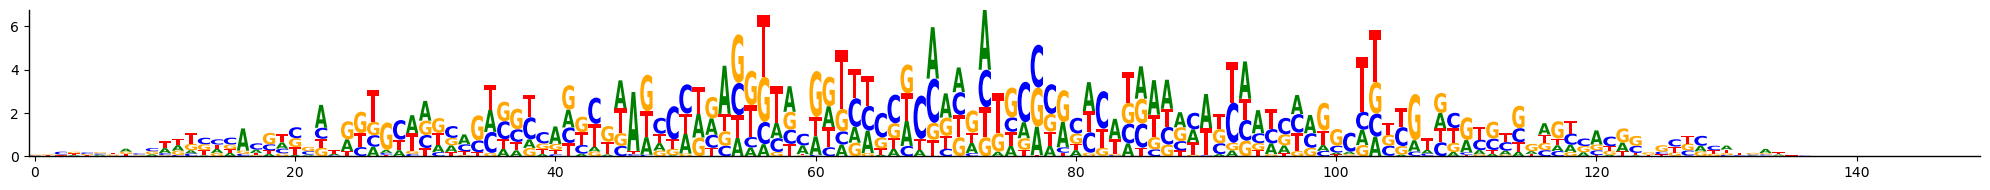

In [885]:
def dna_attribution_plot1(attribution_value):
 
    plt.figure(figsize=(20,2))

    ax1=plt.subplot(1,1,1)
    atr_dataframe=pd.DataFrame(attribution_value.cpu().detach().squeeze(0).T,columns=['A','C','G','T'])
    logo=logomaker.Logo(atr_dataframe, shade_below=.5, fade_below=.5,ax=ax1)
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)

    plt.tight_layout()

dna_attribution_plot1(saliency_grads)

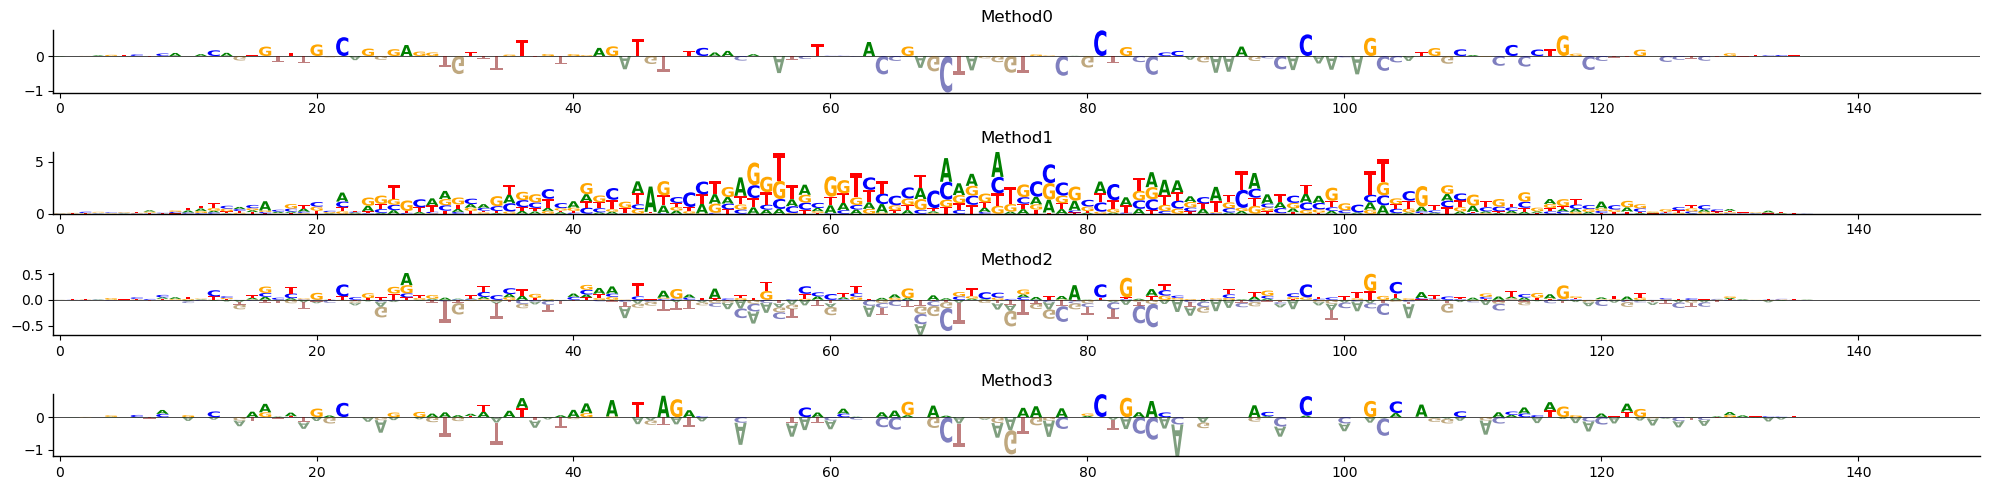

In [940]:
def dna_attribution_plot_all(attribution_values):
    
    num_rows=len(attribution_values)
    num_cols=1
    
    plt.figure(figsize=(20,5))

    
    for i in range(len(attribution_values)):
        
        ax1=plt.subplot(num_rows,num_cols,i+1)
        atr_dataframe=pd.DataFrame(attribution_values[i].cpu().detach().squeeze(0).T,columns=['A','C','G','T'])
        logo=logomaker.Logo(atr_dataframe, shade_below=.5, fade_below=.5,ax=ax1)
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)
        
        
        ax1.set_title(f"Method{i}")

    plt.tight_layout()

dna_attribution_plot_all(attribution_values)

In [935]:
shape=(4,150,)
baseline= torch.empty(size=(4,4,150))

for i in range(4):
    temp=torch.zeros(shape)
    for j in range(temp.shape[1]):
        temp[i][j]=1
    baseline[i]=temp
baseline=baseline.to(device, dtype=torch.float32)

In [936]:
dls=DeepLiftShap(model)
attribution_dl=attribute_image_features(dls,data_test, target=labels_idx, baselines=baseline)
attribution_values.append(attribution_dl)

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


In [939]:
dl_base=DeepLift(model)
attribution_dl=attribute_image_features(dl_base,data_test, target=labels_idx, baselines=baseline[0].unsqueeze(0))
attribution_values.append(attribution_dl)

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
